In [1]:
drive_path = '/data/dynamic-brain-workshop/brain_observatory_cache/'


In [2]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
import h5py
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as ptchs
%matplotlib notebook

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(drive_path,'brain_observatory_manifest.json')
print manifest_file

boc = BrainObservatoryCache(manifest_file=manifest_file)

/data/dynamic-brain-workshop/brain_observatory_cache/brain_observatory_manifest.json


In [4]:
# Download a list of all targeted areas
targeted_structures = boc.get_all_targeted_structures()
print 'all targeted structures: ' + str(targeted_structures)

cre_lines = boc.get_all_cre_lines()
print 'all cre lines: ' + str(cre_lines)

print boc.get_all_stimuli()

all targeted structures: [u'VISal', u'VISam', u'VISl', u'VISp', u'VISpm', u'VISrl']
all cre lines: [u'Cux2-CreERT2', u'Emx1-IRES-Cre', u'Nr5a1-Cre', u'Rbp4-Cre_KL100', u'Rorb-IRES2-Cre', u'Scnn1a-Tg3-Cre']
['drifting_gratings', 'locally_sparse_noise', 'locally_sparse_noise_4deg', 'locally_sparse_noise_8deg', 'natural_movie_one', 'natural_movie_three', 'natural_movie_two', 'natural_scenes', 'spontaneous', 'static_gratings']


In [ ]:
visual_area = 'VISp'
cre_line = 'Cux2-CreERT2'
exps = boc.get_experiment_containers(targeted_structures=[visual_area], cre_lines=[cre_line])

In [ ]:
df_exps = pd.DataFrame(exps)
df_exps.head()
print "total experiments=", df_exps.shape[0]
# at this point ensure that you don't have ones that have a tag of epilepsy

In [ ]:
expt_container_id = df_exps['id'][2]
expt_session_info = boc.get_ophys_experiments(experiment_container_ids=[expt_container_id])
expt_session_info_df = pd.DataFrame(expt_session_info)
session_id = boc.get_ophys_experiments(experiment_container_ids=[expt_container_id], stimuli=['natural_scenes'])[0]['id']
print session_id

In [ ]:
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)


In [ ]:
cell_ids = data_set.get_cell_specimen_ids()
len(cell_ids)

In [ ]:
traces = data_set.get_corrected_fluorescence_traces(cell_specimen_ids=cell_ids)


In [ ]:
md = data_set.get_metadata()
for key in md.keys():
    print key, md[key]


# All functions

In [5]:

def has_pupil_data(boc,targeted_structures = None,stims = None):
    '''Returns full dataframe with only experiments that have pupil data.
    Input parameters:
            boc = BrainObservatoryCache from allensdk
            //from allensdk.core.brain_observatory_cache import BrainObservatoryCache
            //manifest_file = os.path.join(drive_path,'brain_observatory_manifest.json')
            //boc = BrainObservatoryCache(manifest_file=manifest_file)
            
            structures = list of brain region acronyms, strings (optional)
            
            stims = list of stimulus class names, strings (optional)
            
    Output parameters:
            eye_df = dataframe containing all experiments with eye-tracking data'''
    
    #Imports
    import pandas as pd
       
    if targeted_structures is None:
        targeted_structures = boc.get_all_targeted_structures()
    if stims is None:
        stims = boc.get_all_stimuli()     
   
    filtered_df = pd.DataFrame(boc.get_ophys_experiments(stimuli=stims,targeted_structures = targeted_structures,cre_lines=[cre_line], simple = False))

    eye_df = filtered_df[(filtered_df['fail_eye_tracking'] == False)]
    
    return eye_df


def minimize_patches(std_image, pixels_in_patch, steps=1):

    max_iters_row = np.shape(std_image)[0]-pixels_in_patch
    max_iters_col = np.shape(std_image)[1]-pixels_in_patch
    print max_iters_row, max_iters_col
    all_patches = []
    for i in range(0, max_iters_row, steps):
        for j in range(0, max_iters_col, steps):
            patch_image = std_image[i:i+pixels_in_patch, j:j+pixels_in_patch]
            
            all_patches.append(Patch(patch_image, i, j))
          
    return all_patches

def draw_rectangle(ax, row1, col1, row2, col2):
    from matplotlib.lines import Line2D
    ax.add_line(Line2D([col1,col2], [row1, row1], linewidth=1, color='red'))
    ax.add_line(Line2D([col2,col2], [row1, row2], linewidth=1, color='red'))
    ax.add_line(Line2D([col2,col1], [row2, row2], linewidth=1, color='red'))
    ax.add_line(Line2D([col1,col1], [row1, row2], linewidth=1, color='red'))
    
    
def filter_template_images(image_templates, sigma):
    filtered_images = np.zeros((np.shape(image_templates)))
    for i, image in enumerate(image_templates): 
        print "Filtering template image: ", i
        filtered_images[i] = gaussian_filter(image, sigma)
            
    return filtered_images

def threshold_calcium_signal(trace, stim, sigma, min_frame, max_frame):
    mean = np.mean(trace[stim[1]-30:stim[1]])
    std = np.std(trace[stim[1]-30:stim[1]])
    threshold = mean+sigma*std
    signal = trace[stim[1]+min_frame:stim[2]+max_frame]
    if np.max(signal) > threshold:
        diff = int(np.round(np.max(signal)/threshold))
        return diff
    else:
        return 0
    
def get_interesting_images(filtered_images, traces, stims_table, sigma, coi=None):
    all_above_threshold_images = []
    image_histogram = np.zeros((118))
    if coi is not None:
        trace = traces[coi]
        event_counter = 0
        threshold_images = []
        for count, stim in stims_table.iterrows():
            diff = threshold_calcium_signal(trace, stim, sigma, 4, 0)
            for i in range(diff):
                event_counter += 1
                threshold_images.append(filtered_images[stim[0]])
                
        all_above_threshold_images.append(threshold_images)
        print event_counter, " images above threshold for specific cell number ", coi
        
    else:
        for cell_count, trace in enumerate(traces):
            threshold_images = []
            event_counter = 0
            for count, stim in stims_table.iterrows():
                diff = threshold_calcium_signal(trace, stim, sigma, 4, 0)
                if diff > 1 :
                    diff = 1
                for i in range(diff):
                    event_counter += 1
                    threshold_images.append(filtered_images[stim[0]])
                    image_histogram[stim[0]] += 1

            if event_counter > 500:    
                all_above_threshold_images.append(threshold_images)
                print event_counter, " images above threshold for cell number ", cell_count
            


    return all_above_threshold_images, image_histogram


def gabor_fn(sigma, theta, Lambda, psi, gamma):
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3 # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation 
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb


(601, 601)


<IPython.core.display.Javascript object>


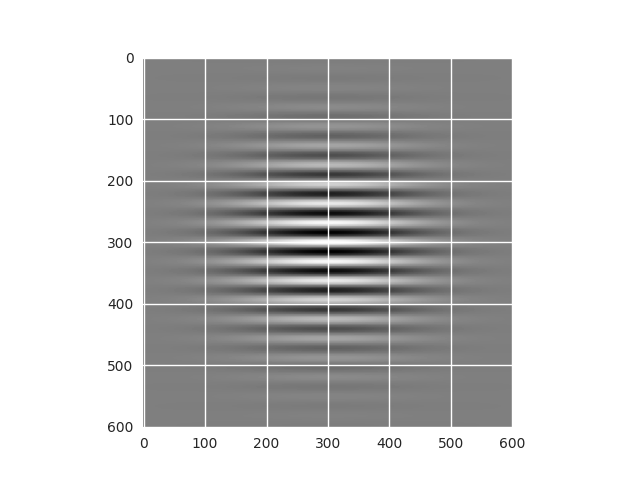

In [6]:
test_gb = gabor_fn(100, np.pi, 10*np.pi, 0, 1)
print test_gb.shape

fig, ax = plt.subplots()
ax.imshow(test_gb, cmap='gray')
plt.show()

# Patch Class

In [7]:
class Patch:
    def __init__(self, image, top_row, leftmost_col):
        self.image = image
        self.mean = np.mean(image)
        self.row = top_row
        self.col = leftmost_col
    
    def display_image(self):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        print "Mean is: ", self.mean
        print "Location: ", self.row, self.col
        
    def __eq__(self, other):
        if isinstance(other, Patch):
            return self.mean == other.mean
        else:
            raise NotImplementedError("The other class was not a Patch object")

    def __lt__(self, other):
        if isinstance(other, Patch):
            return self.mean < other.mean
        else:
            raise NotImplementedError("The other class was not a Patch object")
            
    def __gt__(self, other):
        if isinstance(other, Patch):
            return self.mean > other.mean
        else:
            raise NotImplementedError("The other class was not a Patch object")

    def __le__(self, other):
        if isinstance(other, Patch):
            return self.mean <= other.mean
        else:
            raise NotImplementedError("The other class was not a Patch object")
            
    def __ge__(self, other):
        if isinstance(other, Patch):
            return self.mean >= other.mean
        else:
            raise NotImplementedError("The other class was not a Patch object")
            
    

            
# Test:
A = Patch(np.array([1]*10), 0, 0)
B = Patch(np.array([2]*10), 0, 0)
C = Patch(np.array([3]*10), 0, 0)
D = Patch(np.array([6]*10), 0, 0)
E = Patch(np.array([1]*10), 0, 0)

assert A<B
assert C>B
assert A==E
assert C>=B
assert B<=C

In [8]:
soi = 'natural_scenes'
session_type = 1

In [ ]:
#data_set = boc.get_ophys_experiment_data(eye_df.id)
exp_id = 511510989
exps = boc.get_ophys_experiments(experiment_container_ids=[exp_id])
data_set = boc.get_ophys_experiment_data(exps[session_type]['id'])
print exps[session_type]['session_type']


In [ ]:
image_templates = data_set.get_stimulus_template(soi)
print "Image Templates shape: ", image_templates.shape

if 'sparse' in soi:
    filtered_images = image_templates
else:
    filtered_images = filter_template_images(image_templates, 20)   

In [ ]:
cell_ids = data_set.get_cell_specimen_ids()
traces = data_set.get_dff_traces(cell_specimen_ids=cell_ids)[1]

print "Shape of traces: ", traces.shape


In [ ]:
chosen_cell_index = np.where(cell_ids == 517537780)[0][0]
#chosen_cell_index = 48
print chosen_cell_index

In [ ]:
#stims_epoch = data_set.get_stimulus_epoch_table()
stims_table = data_set.get_stimulus_table(soi)
print "Size of table: ", stims_table.shape

In [ ]:
all_images = get_interesting_images(filtered_images, traces, stims_table, 2.5, chosen_cell_index)

In [ ]:
std_image = np.var(all_images[0], axis=0) / np.var(filtered_images, axis=0)


In [ ]:
ppd = 1174/120.
#ppd = 28./120
max_visual_angle = 20
pixels_in_patch = int(ppd*max_visual_angle)
print pixels_in_patch

In [ ]:
patches = minimize_patches(std_image, pixels_in_patch)

In [ ]:

patches.sort()
min_patch_row = patches[0].row
min_patch_col = patches[0].col
patches[0].display_image()

In [ ]:


mean_image = np.asarray(all_images[0])[:, min_patch_row:min_patch_row+pixels_in_patch,
                                                          min_patch_col:min_patch_col+pixels_in_patch]
mean_image = np.mean(mean_image, axis=0)

fig, ax = plt.subplots(2, 1, figsize=(8, 10))  
ax[0].matshow(mean_image, cmap='gray')
ax[1].matshow(std_image, cmap='gray')
draw_rectangle(ax[1], min_patch_row, min_patch_col,
               min_patch_row+pixels_in_patch, 
               min_patch_col+pixels_in_patch)

In [24]:
sns.set()
sns.set_style('white')
soi = 'natural_scenes'
ppd = 1174/120.
#ppd = 28./120
max_visual_angle = 8
pixels_in_patch = int(ppd*max_visual_angle)
print pixels_in_patch
session_type = -1


#data_set = boc.get_ophys_experiment_data(eye_df.id)
exp_id = 561312433
exps = boc.get_ophys_experiments(experiment_container_ids=[exp_id])
for e, exp in enumerate(exps):
    if "B" in exp['session_type']:
        session_type = e
        
data_set = boc.get_ophys_experiment_data(exps[session_type]['id'])
print exps[session_type]['session_type']

image_templates = data_set.get_stimulus_template(soi)
print "Image Templates shape: ", image_templates.shape

if 'sparse' in soi:
    filtered_images = image_templates
else:
    filtered_images = filter_template_images(image_templates, 20)   

cell_ids = data_set.get_cell_specimen_ids()
traces = data_set.get_dff_traces(cell_specimen_ids=cell_ids)[1]

print "Shape of traces: ", traces.shape

stims_table = data_set.get_stimulus_table(soi)
print "Size of table: ", stims_table.shape

all_images, histogram = get_interesting_images(filtered_images, traces, stims_table, 2.5)

figH, axh = plt.subplots(1,1, figsize=(10, 10))

axh.bar(np.arange(118)+0.3, histogram, 0.95)
axh.set_title("Histogram of preferred images for: "+ str(exp_id))
axh.set_xlabel("Image index")
axh.set_ylabel("Image counts")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10,10))  
fig2= plt.figure(figsize=(10, 10))
fig2.suptitle("Experiment ID:"+str(exp_id)+" Patches: " + str(len(all_images)))
for i in range(len(all_images)):
    std_image = np.var(all_images[i], axis=0) / np.var(filtered_images, axis=0)
    patches = minimize_patches(std_image, pixels_in_patch)

    patches.sort()
    min_patch_row = patches[0].row
    min_patch_col = patches[0].col

    mean_image = np.asarray(all_images[i])[:, min_patch_row:min_patch_row+pixels_in_patch,
                                            min_patch_col:min_patch_col+pixels_in_patch]
    mean_image = np.mean(mean_image, axis=0)

    if i==0: 
        fig.suptitle("Experiment ID: " +str(exp_id))
        ax.matshow(std_image, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        
    ax2 = fig2.add_subplot(len(all_images)/5, 5, i)
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False) 
    ax2.matshow(mean_image, cmap='gray')

    ax.add_patch(ptchs.Rectangle((min_patch_col, min_patch_row), pixels_in_patch, pixels_in_patch, color='r', alpha=0.5))
    #draw_rectangle(ax[0], min_patch_row, min_patch_col,
    #               min_patch_row+pixels_in_patch, 
    #               min_patch_col+pixels_in_patch)

plt.show()

78
three_session_B
Image Templates shape:  (118, 918, 1174)
Filtering template image:  0
Filtering template image:  1
Filtering template image:  2
Filtering template image:  3
Filtering template image:  4
Filtering template image:  5
Filtering template image:  6
Filtering template image:  7
Filtering template image:  8
Filtering template image:  9
Filtering template image:  10
Filtering template image:  11
Filtering template image:  12
Filtering template image:  13
Filtering template image:  14
Filtering template image:  15
Filtering template image:  16
Filtering template image:  17
Filtering template image:  18
Filtering template image:  19
Filtering template image:  20
Filtering template image:  21
Filtering template image:  22
Filtering template image:  23
Filtering template image:  24
Filtering template image:  25
Filtering template image:  26
Filtering template image:  27
Filtering template image:  28
Filtering template image:  29
Filtering template image:  30
Filtering template i

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

840 1096


ValueError: num must be 1 <= num <= 10, not 0

In [32]:
fig.figsize=(20, 5)
for i in range(len(all_images)):
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
plt.show()

TypeError: 'AxesSubplot' object has no attribute '__getitem__'

In [ ]:
max_proj = data_set.get_max_projection()
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(max_proj, cmap='gray')


In [15]:
image_templates.shape
#np.save("natural_images.npy", arr=image_templates)

(118, 918, 1174)

<IPython.core.display.Javascript object>


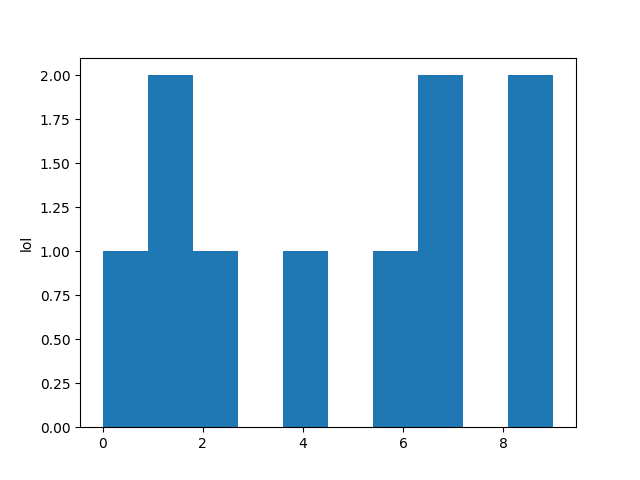

In [28]:
f, a = plt.subplots(1, 1)
rofl = np.zeros((10))
for i in range(10):
    rofl[i] = np.random.randint(0, 10)
    
a.hist(rofl)
a.set_ylabel("lol")
plt.show()

<IPython.core.display.Javascript object>


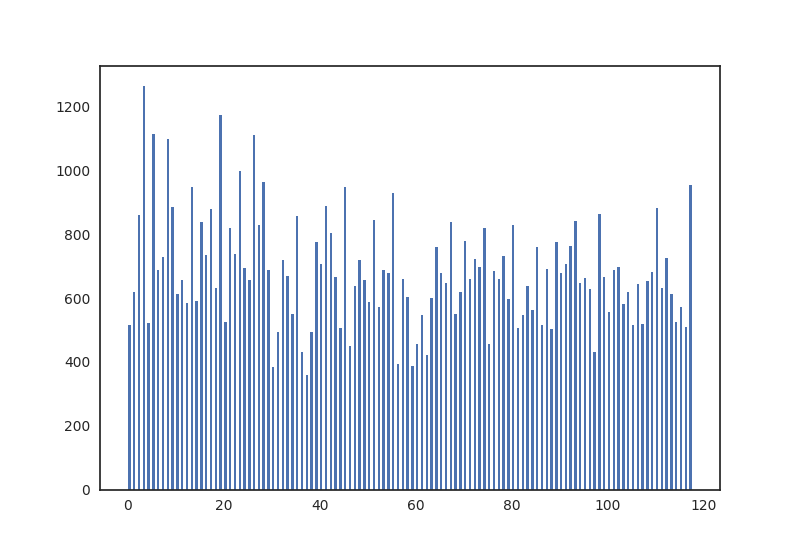

(array([30, 37, 56, 59]),)


In [22]:
fig, ax = plt.subplots(1, 1, )
ax.bar(np.arange(118)+0.3, histogram, 0.5)
print np.where(histogram < 400)